In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

/home/dcsoft/miniconda3/envs/clpy36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dcsoft/miniconda3/envs/clpy36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dcsoft/miniconda3/envs/clpy36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dcsoft/miniconda3/envs/clpy36/lib/pyt

In [20]:
#This is from https://github.com/aakhundov/tf-example-models
import matplotlib.patches as pat
DIMENSIONS = 2
COMPONENTS = 3
DATA_POINTS = 300
EM_STEPS = 25


In [3]:
def _generate_covariances(components, dimensions, diagonal=False, isotropic=False):
    """Generates a batch of random positive definite covariance matrices"""
    covariances = np.zeros((components, dimensions, dimensions))

    if isotropic:
        for i in range(components):
            covariances[i] = np.diag(np.full((dimensions,), np.abs(np.random.normal())))
    elif diagonal:
        for i in range(components):
            covariances[i] = np.diag(np.abs(np.random.normal(size=[dimensions])))
    else:
        for i in range(components):
            covariances[i] = np.random.normal(size=[dimensions, dimensions])
            covariances[i] = np.dot(covariances[i], covariances[i].T)

    return covariances


def generate_gmm_data(size, components, dimensions, seed=None, diagonal=False, isotropic=False, nan_fraction=0):
    """Generates synthetic data of a given size from a random Gaussian Mixture Model,
    non_franction is the fraction of the elements that should be nan
    """
    np.random.seed(seed)

    means = np.random.normal(size=[components, dimensions]) * 10
    covariances = _generate_covariances(components, dimensions, diagonal, isotropic)
    weights = np.ones(components)/components
    #weights = np.abs(np.random.normal(size=[components]))
    #weights /= np.sum(weights)

    
    result = np.empty((size, dimensions), dtype=np.float32)
    responsibilities = np.empty((size,), dtype=np.int32)

    for i in range(size):
        comp = np.random.choice(components, p=weights)

        responsibilities[i] = comp
        result[i] = np.random.multivariate_normal(
            means[comp], covariances[comp]
        )
    
    result.ravel()[np.random.choice(result.size, int(nan_fraction*result.size), replace=False)] = np.nan
    
    np.random.seed()

    return result, means, covariances, weights, responsibilities

In [4]:
#This is from https://github.com/aakhundov/tf-example-models
def _plot_gaussian(mean, covariance, color, zorder=0):
    """Plots the mean and 2-std ellipse of a given Gaussian"""
    plt.plot(mean[0], mean[1], color[0] + ".", zorder=zorder)

    if covariance.ndim == 1:
        covariance = np.diag(covariance)

    radius = np.sqrt(5.991)
    eigvals, eigvecs = np.linalg.eig(covariance)
    axis = np.sqrt(eigvals) * radius
    slope = eigvecs[1][0] / eigvecs[1][1]
    angle = 180.0 * np.arctan(slope) / np.pi

    plt.axes().add_artist(pat.Ellipse(
        mean, 2 * axis[0], 2 * axis[1], angle=angle,
        fill=False, color=color, linewidth=1, zorder=zorder
    ))


def plot_fitted_data(data, means, covariances, true_means=None, true_covariances=None):
    """Plots the data and given Gaussian components"""
    plt.plot(data[:, 0], data[:, 1], "b.", markersize=0.5, zorder=0)

    if true_means is not None:
        for i in range(len(true_means)):
            _plot_gaussian(true_means[i], true_covariances[i], "green", 1)

    for i in range(len(means)):
        _plot_gaussian(means[i], covariances[i], "red", 2)

    plt.show()

In [5]:
def initial_means(x):
    # TODO resample at each step s.t. it won't try to effect the specific X values we choose as means
    #rand_point_ids = tf.squeeze(tf.multinomial(tf.ones([1, tf.shape(x)[0]]), COMPONENTS))
    #return tf.Variable(tf.gather(x, rand_point_ids), dtype=tf.float32, name='initial_means', trainable=False)
    return tf.Variable(tf.gather(x, [1,2,8]), dtype=tf.float32, name='initial_means', trainable=False)

def initial_covariances(x):
    # computing input statistics
    #dim_means = tf.reduce_mean(x, 0)
    #dim_distances = tf.squared_difference(x, tf.expand_dims(dim_means, 0))
    #dim_variances = tf.reduce_sum(dim_distances, 0) / tf.cast(tf.shape(x)[0], tf.float32)
    #avg_variance = tf.cast(tf.reduce_sum(dim_variances) / DIMENSIONS**2, tf.float32)
    #return tf.Variable(tf.cast(tf.ones([COMPONENTS, DIMENSIONS,DIMENSIONS]), tf.float32) * avg_variance, name='initial_variances', trainable=False)
    return tf.Variable(tf.tile(tf.reshape(10*tf.eye(DIMENSIONS, dtype=tf.float32),(1,DIMENSIONS,DIMENSIONS)),[COMPONENTS,1,1]), name='initial_variances', trainable=False)

def initial_alphas():
    return tf.Variable(tf.cast(tf.fill([COMPONENTS], 1. / COMPONENTS), tf.float32), name='initial_alphas', trainable=False)

#NP
def initial_means(x):
    # TODO resample at each step s.t. it won't try to effect the specific X values we choose as means
    #rand_point_ids = tf.squeeze(tf.multinomial(tf.ones([1, tf.shape(x)[0]]), COMPONENTS))
    #return tf.Variable(tf.gather(x, rand_point_ids), dtype=tf.float32, name='initial_means', trainable=False)
    return x[[0,1,2],:]

def initial_covariances(x):
    # computing input statistics
    #dim_means = tf.reduce_mean(x, 0)
    #dim_distances = tf.squared_difference(x, tf.expand_dims(dim_means, 0))
    #dim_variances = tf.reduce_sum(dim_distances, 0) / tf.cast(tf.shape(x)[0], tf.float32)
    #avg_variance = tf.cast(tf.reduce_sum(dim_variances) / DIMENSIONS**2, tf.float32)
    #return tf.Variable(tf.cast(tf.ones([COMPONENTS, DIMENSIONS,DIMENSIONS]), tf.float32) * avg_variance, name='initial_variances', trainable=False)
    return np.tile(np.reshape(10*np.eye(DIMENSIONS, dtype=np.float32),(1,DIMENSIONS,DIMENSIONS)),[COMPONENTS,1,1])

def initial_alphas():
    return np.ones(COMPONENTS) * (1. / COMPONENTS)

#NP
def p_k(x, means, covariances):
    import numpy as tf
    tf.reduce_mean = tf.mean
    tf.reduce_sum = tf.sum
    x_minus_mu = tf.expand_dims(x,0)-tf.expand_dims(means,1)
    inv_sigma = tf.linalg.inv(covariances)
    exponent=-1/2*tf.einsum('cbi,cij,cbj->bc', x_minus_mu, inv_sigma, x_minus_mu)
    unnormalized_pdf = tf.exp(exponent)
    tmp = tf.linalg.det(covariances)
    normalizing_constant = ((2*math.pi)**(DIMENSIONS/2)) * tf.sqrt(tmp)
    return unnormalized_pdf/normalizing_constant

def reweights(p_k, alphas):
    import numpy as tf
    tf.reduce_mean = tf.mean
    tf.reduce_sum = tf.sum
    nominator = p_k*alphas
    return nominator/tf.linalg.norm(nominator, ord=1, axis=1, keepdims=True)

def realphas(weights):
    import numpy as tf
    tf.reduce_mean = tf.mean
    tf.reduce_sum = tf.sum
    return tf.reduce_mean(weights,axis=0)
def remeans(x, weights):
    import numpy as tf
    tf.reduce_mean = tf.mean
    tf.reduce_sum = tf.sum
    tf.is_nan = tf.isnan
    nan_mask = tf.tile(tf.expand_dims(tf.is_nan(x),1),(1,COMPONENTS,1))
    zeros_mat = tf.zeros_like(nan_mask, dtype=tf.float32)

    expanded_weights = tf.tile(tf.expand_dims(weights,2), (1,1,DIMENSIONS))
    masked_weights = tf.where(nan_mask, zeros_mat, expanded_weights)

    weighted_x = masked_weights*x
    weighted_x_no_nan = tf.where(nan_mask, zeros_mat, weighted_x)

    nan_aware_normalization = tf.reduce_sum(masked_weights,axis=0)

    return tf.reduce_mean(weighted_x_no_nan,axis=0)/nan_aware_normalization
def recovariances(x,means,weights):
    import numpy as tf
    tf.reduce_mean = tf.mean
    tf.reduce_sum = tf.sum
    tf.is_nan = tf.isnan
    x_minus_mu_with_nans = tf.expand_dims(x,0)-tf.expand_dims(means,1)
    x_minus_mu = tf.where(tf.is_nan(x_minus_mu_with_nans), tf.zeros_like(x_minus_mu_with_nans), x_minus_mu_with_nans)
    x_xT = tf.einsum('cbi,cbj->bcij', x_minus_mu, x_minus_mu)
    nan_mask = tf.is_nan(x_xT)
    expanded_weights = tf.tile(tf.expand_dims(tf.expand_dims(weights,2),3),(1,1,DIMENSIONS,DIMENSIONS))

    weighted_covariances = expanded_weights*x_xT
    zero_mat = tf.zeros_like(nan_mask, dtype=tf.float32)

    unnormalized_covariances = tf.reduce_sum(tf.where(nan_mask, zero_mat, weighted_covariances),axis=0)
    nan_aware_normalization = tf.reduce_sum(tf.where(nan_mask, zero_mat, expanded_weights),axis=0)
    return unnormalized_covariances/nan_aware_normalization


#sig_mu = tf.einsum('c,bc,cbi,cbj->cij', (1/tf.reduce_sum(weights,axis=0)),weights,x_minus_mu,x_minus_mu)

init_mu, init_sig, init_alpha = initial_means(xx), initial_covariances(xx), initial_alphas()
mu, sig, alpha = init_mu, init_sig, init_alpha
for i in range(EM_STEPS):
    w = Expectation(xx, mu, sig, alpha)
    
    alpha = realphas(w)
    mu  = remeans(xx, w)
    sig = recovariances(xx, mu, w)
    
    plot_fitted_data(
    xx[:, :2], mu[:, :2], sig[:, :2, :2],
    true_means[:, :2], true_variances[:, :2, :2]
    )
    print(mu)
    print()


In [6]:
def p_k(x, means, covariances):
    """using the marginal probability of the non-nan values. 
    This is performed by replacing the nan with 0 after calculating x-mu,
    which corresponds to looking at the sub covariance matrix that only has the non nan dimensions,
    which is the marginal probability of the observed values of the point
    """
    x_minus_mu_with_nans = tf.expand_dims(x,0)-tf.expand_dims(means,1)
    x_minus_mu = tf.where(tf.is_nan(x_minus_mu_with_nans), tf.zeros_like(x_minus_mu_with_nans), x_minus_mu_with_nans)
    inv_sigma = tf.linalg.inv(covariances)
    exponent=-1/2*tf.einsum('cbi,cij,cbj->bc', x_minus_mu, inv_sigma, x_minus_mu)
    unnormalized_pdf = tf.exp(exponent)
    normalizing_constant = ((2*math.pi)**(DIMENSIONS/2)) * tf.sqrt(tf.linalg.det(covariances))
    return unnormalized_pdf/normalizing_constant

def reweights(p_k, alphas):
    nominator = p_k*alphas
    return nominator/tf.linalg.norm(nominator, ord=1, axis=1, keepdims=True)

def realphas(weights):
    return tf.reduce_mean(weights,axis=0)

def remeans(x, weights):
    nan_mask = tf.tile(tf.expand_dims(tf.is_nan(x),1),(1,COMPONENTS,1))
    zeros_mat = tf.zeros_like(nan_mask, dtype=tf.float32)

    expanded_weights = tf.tile(tf.expand_dims(weights,2), (1,1,DIMENSIONS))
    masked_weights = tf.where(nan_mask, zeros_mat, expanded_weights)

    weighted_x = tf.einsum('bci,bi->bci',masked_weights,x)
    weighted_x_no_nan = tf.where(nan_mask, zeros_mat, weighted_x)

    nan_aware_normalization = tf.reduce_sum(masked_weights,axis=0)

    return tf.reduce_sum(weighted_x_no_nan,axis=0)/nan_aware_normalization

def recovariances(x,means,weights):
    x_minus_mu_with_nans = tf.expand_dims(x,0)-tf.expand_dims(means,1)
    x_minus_mu = tf.where(tf.is_nan(x_minus_mu_with_nans), tf.zeros_like(x_minus_mu_with_nans), x_minus_mu_with_nans)
    x_xT = tf.einsum('cbi,cbj->bcij', x_minus_mu, x_minus_mu)
    nan_mask = tf.is_nan(x_xT)
    expanded_weights = tf.tile(tf.expand_dims(tf.expand_dims(weights,2),3),(1,1,DIMENSIONS,DIMENSIONS))

    weighted_covariances = expanded_weights*x_xT
    zero_mat = tf.zeros_like(nan_mask, dtype=tf.float32)

    unnormalized_covariances = tf.reduce_sum(tf.where(nan_mask, zero_mat, weighted_covariances),axis=0)
    nan_aware_normalization = tf.reduce_sum(tf.where(nan_mask, zero_mat, expanded_weights),axis=0)
    return unnormalized_covariances/nan_aware_normalization


#sig_mu = tf.einsum('c,bc,cbi,cbj->cij', (1/tf.reduce_sum(weights,axis=0)),weights,x_minus_mu,x_minus_mu)

In [7]:
def Expectation(x, means, covariances, alphas):
    return reweights(p_k(x,means,covariances)+1e-30, alphas)

def Maximization(x, weights):
    alphas = realphas(weights)
    means  = remeans(x, weights)
    covariances = recovariances(x, means, weights)
    return (means, covariances, alphas)

def one_step_EM(x, means, covariances, alphas):
    w = Expectation(x, means, covariances, alphas)
    new_means, new_covariances, new_alphas = Maximization(x, w)
    return new_means, new_covariances, new_alphas, w

In [8]:
xx, true_means, true_variances, true_weights, _ = generate_gmm_data(DATA_POINTS, COMPONENTS, DIMENSIONS, 20, nan_fraction=0.2)

In [9]:
xx = xx[~np.isnan(xx).all(axis=1)]
DATA_POINTS = xx.shape[0]

In [10]:
xx[:10]

array([[        nan, -23.703028 ],
       [  4.5267196, -22.258944 ],
       [ 11.632245 ,   1.9581258],
       [        nan, -24.355938 ],
       [  3.568774 , -25.64547  ],
       [  2.8000824,         nan],
       [  7.2158575,   2.1039298],
       [  9.603476 ,         nan],
       [ -9.76468  ,   6.1456556],
       [  4.5526953, -22.163347 ]], dtype=float32)

In [21]:
tf.reset_default_graph()
init_mu, init_sig, init_alpha = initial_means(xx), initial_covariances(xx), initial_alphas()
mu, sig, alpha = init_mu, init_sig, init_alpha
x_ph = tf.placeholder(tf.float32, [None, DIMENSIONS], name='inputTENSOR')

for i in range(EM_STEPS):
    mu, sig, alpha, _ = one_step_EM(x_ph, mu, sig, alpha)


In [ ]:
tf.reset_default_graph()
sess = tf.Session()

init_mu, init_sig, init_alpha = initial_means(xx), initial_covariances(xx), initial_alphas()
mu, sig, alpha = init_mu, init_sig, init_alpha
x_ph = tf.placeholder(tf.float32, [None, DIMENSIONS], name='inputTENSOR')

x, means, covariances, alphas = x_ph, mu, sig, alpha

pk = p_k(x,means,covariances)
w = reweights(pk+1e-20, alphas)

weights = w
alphas = realphas(weights)
means  = remeans(x, weights)
covariances = recovariances(x, means, weights)
new_means, new_covariances, new_alphas = (means, covariances, alphas)



mu, sig, alpha, _ =  new_means, new_covariances, new_alphas, w

sess.run(tf.global_variables_initializer(), feed_dict={x_ph: xx})
print("x",xx[:9,:])
print("pk",sess.run([pk[:9,:]], feed_dict={x_ph: xx}))
print("W",sess.run([w[:9,:]], feed_dict={x_ph: xx}))
print("mu0",sess.run([init_mu], feed_dict={x_ph: xx}))
print("sig0:3",sess.run([init_sig], feed_dict={x_ph: xx}))
print("true mu",true_means)
print("mu1",sess.run([mu], feed_dict={x_ph: xx}))
print("alph",sess.run([alphas], feed_dict={x_ph: xx}))



In [ ]:
tf.reset_default_graph()
sess = tf.Session()

init_mu, init_sig, init_alpha = initial_means(xx), initial_covariances(xx), initial_alphas()
mu, sig, alpha = init_mu, init_sig, init_alpha
x_ph = tf.placeholder(tf.float32, [None, DIMENSIONS], name='inputTENSOR')

x, means, covariances, alphas = x_ph, mu, sig, alpha
pk = p_k(x,means,covariances)
w = reweights(pk+1e-20, alphas)

weights = w

nan_mask = tf.tile(tf.expand_dims(tf.is_nan(x),1),(1,COMPONENTS,1))
zeros_mat = tf.zeros_like(nan_mask, dtype=tf.float32)

expanded_weights = tf.tile(tf.expand_dims(weights,2), (1,1,DIMENSIONS))
masked_weights = tf.where(tf.is_nan(expanded_weights), zeros_mat, expanded_weights)

weighted_x = tf.einsum('bci,bi->bci',masked_weights,x)
weighted_x_no_nan = tf.where(nan_mask, zeros_mat, weighted_x)

nan_aware_normalization = tf.reduce_sum(masked_weights,axis=0)
unnormalized = tf.reduce_sum(weighted_x_no_nan,axis=0)
new_means = unnormalized/nan_aware_normalization

prev = tf.einsum('c,bc,bi->ci', (1/tf.reduce_sum(weights,axis=0)),weights,x)
weight_norm = (1/tf.reduce_sum(weights,axis=0))
weighted_x1 = tf.einsum('bc,bi->ci', weights, x)
normalized = tf.einsum('c,ci->ci', weight_norm, weighted_x1)
sess.run(tf.global_variables_initializer(), feed_dict={x_ph: xx})

print("x",xx[:10,:])
print("pk", sess.run([pk[:6,:]], feed_dict={x_ph: xx}))
"""print("W",sess.run([w[:6,:]], feed_dict={x_ph: xx}))
print("mu0",sess.run([init_mu], feed_dict={x_ph: xx}))
print("sig0:3",sess.run([init_sig], feed_dict={x_ph: xx}))
print("true mu",true_means)
"""
print("mu1",sess.run([new_means], feed_dict={x_ph: xx}))
print("prev",sess.run([prev], feed_dict={x_ph: xx}))


print("masked_weights",sess.run([masked_weights[:9]], feed_dict={x_ph: xx}))
print("weights",sess.run([weights[:9]], feed_dict={x_ph: xx}))


print("unnormalized",sess.run([unnormalized[:9]], feed_dict={x_ph: xx}))
print("weightedx1",sess.run([weighted_x1[:9]], feed_dict={x_ph: xx}))


In [ ]:
x_minus_mu = tf.expand_dims(x,0)-tf.expand_dims(initial_means(x),1)
    w_mu = tf.einsum('bc,cbj->cbj', weights, x_minus_mu)
    w_mu_muT = tf.einsum('cbj,cbi->cij', x_minus_mu, w_mu)
    return tf.einsum('c,cij->cij', (1/tf.reduce_sum(weights,axis=0)),w_mu_muT)

x_ph = tf.placeholder(tf.float32, [None, DIMENSIONS], name='inputTENSOR')
x, means, covariances, alphas = x_ph, mu, sig, alpha
w = Expectation(x, means, covariances, alphas)

alphas = realphas(w)
means  = remeans(x, w)
covariances = recovariances(x, means, w)

weights = w
nan_mask = tf.tile(tf.expand_dims(tf.is_nan(x),1),(1,COMPONENTS,1))
zeros_mat = tf.zeros_like(nan_mask, dtype=tf.float32)

expanded_weights = tf.tile(tf.expand_dims(weights,2), (1,1,DIMENSIONS))
masked_weights = tf.where(nan_mask, zeros_mat, expanded_weights)

weighted_x = tf.einsum('bci,bi->bci',masked_weights,x)
weighted_x_no_nan = tf.where(nan_mask, zeros_mat, weighted_x)

nan_aware_normalization = tf.reduce_sum(masked_weights,axis=0)

tf.reduce_mean(weighted_x_no_nan,axis=0)/nan_aware_normalization

(masked_weights*x).shape

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer(), feed_dict={x_ph: xx})

sess.run(tf.reduce_mean(weighted_x_no_nan,axis=0)/nan_aware_normalization, feed_dict={x_ph: xx})

new_means, new_covariances, new_alphas = Maximization(x, w)

new_means, new_covariances, new_alphas, w

    

In [23]:
final_means,final_covariances = sess.run([mu, sig], feed_dict={x_ph: xx})

/home/dcsoft/miniconda3/envs/clpy36/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


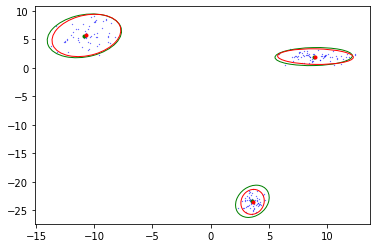

In [24]:
plot_fitted_data(
    xx[:, :2], final_means[:, :2], final_covariances[:, :2, :2],
    true_means[:, :2], true_variances[:, :2, :2]
)

In [ ]:
final_means

In [ ]:
final_means, final_covariances

In [ ]:
def p_k(x, means, covariances):
    x_minus_mu = tf.expand_dims(x,0)-tf.expand_dims(means,1)
    inv_sigma = tf.linalg.inv(covariances)
    exponent=-1/2*tf.einsum('cbi,cij,cbj->bc', x_minus_mu, inv_sigma, x_minus_mu)
    unnormalized_pdf = tf.exp(exponent)
    normalizing_constant = ((2*math.pi)**(DIMENSIONS/2)) * tf.sqrt(tf.linalg.det(covariances))
    return unnormalized_pdf/normalizing_constant

def reweights(p_k, alphas):
    nominator = p_k*alphas
    return nominator/tf.linalg.norm(nominator, ord=1, axis=1, keepdims=True)

def realphas(weights):
    return tf.reduce_mean(weights,axis=0)
def remeans(x, weights):
    return tf.einsum('c,bc,bi->ci', (1/tf.reduce_sum(weights,axis=0)),weights,x)
def recovariances(x,means,weights):
    x_minus_mu = tf.expand_dims(x,0)-tf.expand_dims(means,1)
    w_mu = tf.einsum('bc,cbj->cbj', weights, x_minus_mu)
    w_mu_muT = tf.einsum('cbj,cbi->cij', x_minus_mu, w_mu)
    return tf.einsum('c,cij->cij', (1/tf.reduce_sum(weights,axis=0)),w_mu_muT)

def Expectation(x, means, covariances, alphas):
    return reweights(p_k(x,means,covariances), alphas)

def Maximization(x, weights):
    alphas = realphas(weights)
    means  = remeans(x, weights)
    covariances = recovariances(x, means, weights)
    return (means, covariances, alphas)

def one_step_EM(x, means, covariances, alphas):
    w = Expectation(x, means, covariances, alphas)
    new_means, new_covariances, new_alphas = Maximization(x, w)
    return new_means, new_covariances, new_alphas, w

tf.reset_default_graph()
sess = tf.Session()
x_ph = tf.placeholder(tf.float32, [None, DIMENSIONS], name='inputTENSOR')
init_mu, init_sig, init_alpha = initial_means(xx), initial_covariances(xx), initial_alphas()
mu, sig, alpha = init_mu, init_sig, init_alpha

for i in range(25):
    mu, sig, alpha, _ = one_step_EM(x_ph, mu, sig, alpha)

sess.run(tf.global_variables_initializer(), feed_dict={x_ph: xx})
final_means0,final_covariances0 = sess.run([mu, sig], feed_dict={x_ph: xx})
plot_fitted_data(
    xx[:, :2], final_means0[:, :2], final_covariances0[:, :2, :2],
    true_means[:, :2], true_variances[:, :2, :2]
)

In [ ]:
final_means0